In [1]:
import pandas
import numpy as np

df = pandas.read_feather('data_dump.bin')



In [2]:
df

,x,y,z
0,0.072,-0.048,-0.856
1,0.072,0.000,-0.848
2,0.032,0.000,-0.848
3,0.128,-0.120,-0.984
4,0.048,-0.032,-0.840
...,...,...,...
44760,0.120,0.016,-0.776
44761,0.088,-0.056,-0.760
44762,0.168,-0.024,-0.736
44763,0.056,0.280,-1.000


In [3]:
df.describe()

,x,y,z
count,44765.000000,44765.000000,44765.000000
mean,0.090017,-0.022997,-0.867976
std,0.035953,0.038861,0.090954
min,0.000000,-0.176000,-1.240000
25%,0.064000,-0.048000,-0.888000
50%,0.080000,-0.016000,-0.856000
75%,0.112000,0.000000,-0.832000
max,0.280000,0.280000,-0.584000


In [4]:
# Remove gravity
df['z'] += 1

In [5]:
df.describe()

,x,y,z
count,44765.000000,44765.000000,44765.000000
mean,0.090017,-0.022997,0.132024
std,0.035953,0.038861,0.090954
min,0.000000,-0.176000,-0.240000
25%,0.064000,-0.048000,0.112000
50%,0.080000,-0.016000,0.144000
75%,0.112000,0.000000,0.168000
max,0.280000,0.280000,0.416000


<AxesSubplot:ylabel='Frequency'>

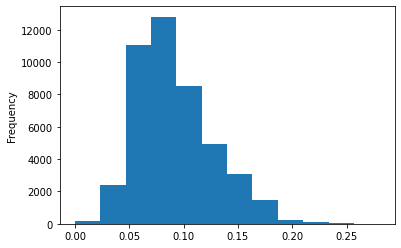

In [7]:
df['x'].plot.hist(bins=12)

In [12]:
df['x'].std()

0.035953337284718785

In [13]:
df.plot.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [14]:
import matplotlib.pyplot as plt

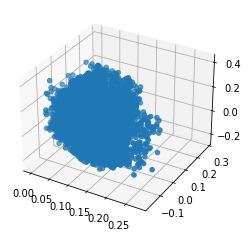

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['x'], df['y'], df['z'])

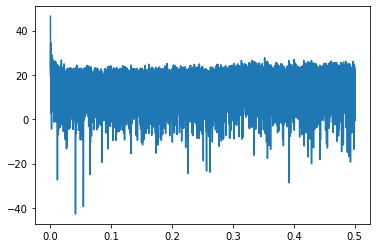

In [31]:
import scipy as sp
x_dps = np.array(df['x'])
x_fft = sp.fftpack.fft(x_dps)

x_psd = np.abs(x_fft) ** 2
x_fftfreq = sp.fftpack.fftfreq(len(x_psd))

i = x_fftfreq > 0

#ax = fig.add_subplot()
plt.plot(x_fftfreq[i], 10 * np.log10(x_psd[i]))
#ax.set_ylabel('PSD (dB)')
#plt.show()